In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import recall_score, precision_score
from sklearn.preprocessing import StandardScaler
from copy import deepcopy
import catboost as cat

from collections import defaultdict
import category_encoders as ce

import os
import pickle

In [2]:
def metric_func(y_true, y_pred):
    return 0.2*recall_score(y_true, y_pred, average="macro", zero_division=0) +\
        0.8*precision_score(y_true, y_pred, average="macro", zero_division=0)

def convert_strDatetime_to_int(series):
    series = pd.to_datetime(series)
    series = series.astype(np.int64) // 10 ** 9
    return series

In [4]:
df = pd.read_csv("train_dataset_train.csv")
df = df.fillna(-9999)

In [5]:
obj_cols = df.dtypes[df.dtypes == "object"].index.drop(['month_id', 'carts_created_at'])
df[obj_cols] = df[obj_cols].astype(str)

time_cols = ['month_id', 'carts_created_at'] 
df[time_cols] = df[time_cols].apply(convert_strDatetime_to_int)

In [6]:
X = df.drop('target', axis=1)
y = df[["target"]]

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Ordinally encoding
encoder = ce.OrdinalEncoder(cols=obj_cols)
encoder.fit(X_train)
X_train = encoder.transform(X_train)
X_test = encoder.transform(X_test)
X_train[obj_cols] = X_train[obj_cols].astype(int)
X_test[obj_cols] = X_test[obj_cols].astype(int)

# Посмотрим на важность признаков с помощью CatBoostClassifier

In [8]:
cat_fi = cat.CatBoostClassifier(task_type='GPU')
cat_fi.fit(X_train,y_train,cat_features=obj_cols.values, eval_set=(X_test, y_test), silent=True)

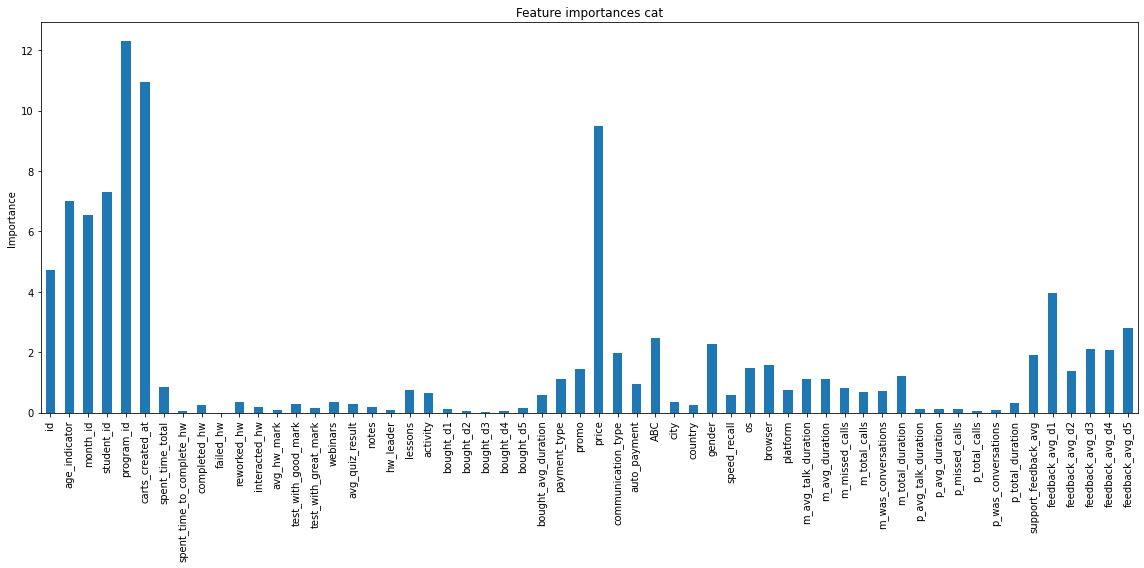

In [9]:
cat_features_importances = cat_fi.get_feature_importance()
cat_importances = pd.Series(cat_features_importances, index=X.columns)

fig, ax = plt.subplots(figsize=(16,8))
cat_importances.plot.bar(ax=ax)
ax.set_title("Feature importances cat")
ax.set_ylabel("Importance")
fig.tight_layout()

In [10]:
useful_feature_idxs = np.where(cat_features_importances > 1)
useful_columns = X.columns[useful_feature_idxs]
print(useful_columns)

Index(['id', 'age_indicator', 'month_id', 'student_id', 'program_id',
       'carts_created_at', 'payment_type', 'promo', 'price',
       'communication_type', 'ABC', 'gender', 'os', 'browser',
       'm_avg_talk_duration', 'm_avg_duration', 'm_total_duration',
       'support_feedback_avg', 'feedback_avg_d1', 'feedback_avg_d2',
       'feedback_avg_d3', 'feedback_avg_d4', 'feedback_avg_d5'],
      dtype='object')


In [11]:
# Выбрано 12 признаков путем ручных тестов
useful_features = ['age_indicator', 'month_id', 'student_id', 'program_id',
       'carts_created_at', 'promo', 'price', 'communication_type',
       'auto_payment', 'ABC', 'gender', 'feedback_avg_d1']

In [12]:
X_train[useful_features].head()

,age_indicator,month_id,student_id,program_id,carts_created_at,promo,price,communication_type,auto_payment,ABC,gender,feedback_avg_d1
21269,12.0,1635638400,7005300,366,1610496000,1,46299.31320,1,0,1,2.0,-9999.000
187660,20.0,1635638400,6825196,910,1602115200,1,17723.34135,2,0,1,0.0,-9999.000
774,28.0,1601424000,6747187,1360,1598313600,1,23222.96794,3,0,1,0.0,4.715
184577,-9999.0,1638230400,6801141,724,1599696000,1,52315.54855,1,1,2,0.0,-9999.000
37127,14.0,1625011200,6724992,166,1597104000,1,13847.58200,1,0,1,1.0,5.000


# Ещё предобработаем данные

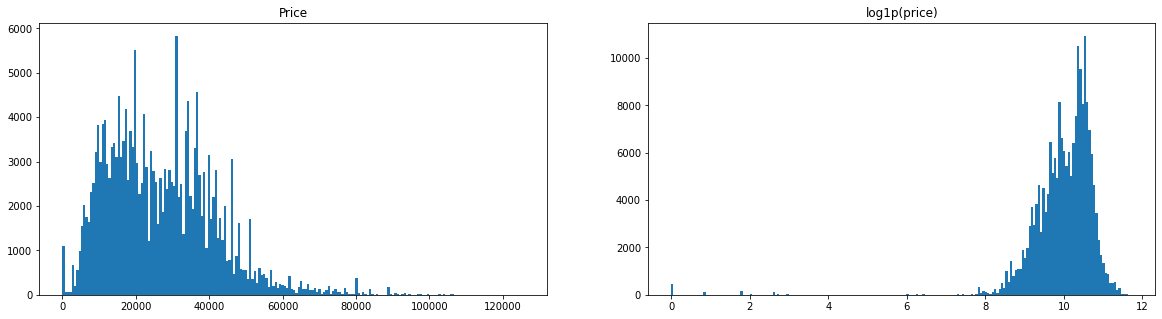

In [13]:
# Посмотрим на распределение цены и log1p цены 
plt.figure(figsize=(20,5))
plt.subplot(121, title='Price')
plt.hist(X['price'], bins=200)
plt.subplot(122, title='log1p(price)')
plt.hist(X['price'].apply(np.log1p), bins=200)
plt.show()
# Очевидно лучше поправить распределение, взяв логарифм

In [14]:
useful_features = ['age_indicator', 'month_id', 'student_id', 'program_id',
       'carts_created_at', 'promo', 'price', 'communication_type',
       'auto_payment', 'ABC', 'gender', 'feedback_avg_d1']

num_features = [
    'age_indicator', 
    'price', 
    'feedback_avg_d1'
]

obj_cols_to_use = np.intersect1d(useful_features, obj_cols)
# array(['ABC', 'communication_type', 'promo'], dtype=object)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Берем log1p от цены
X_train['price'] = X_train['price'].apply(np.log1p)
X_test['price'] = X_test['price'].apply(np.log1p)

d_scaler_std = defaultdict(StandardScaler)
# Нормализуем числовые фичи
num_features_train = X_train[num_features].apply(lambda x: d_scaler_std[x.name].fit_transform(x.values.reshape(-1, 1))[:,0])
num_features_test = X_test[num_features].apply(lambda x: d_scaler_std[x.name].transform(x.values.reshape(-1, 1))[:,0])
X_train.update(num_features_train)
X_test.update(num_features_test)

# Кодируем числами категориальные фичи
encoder = ce.OrdinalEncoder(cols=obj_cols)
encoder.fit(X_train)
X_train = encoder.transform(X_train)
X_test = encoder.transform(X_test)
X_train[obj_cols] = X_train[obj_cols].astype(int)
X_test[obj_cols] = X_test[obj_cols].astype(int)

# Выбираем только нужные 
X_train = X_train[useful_features]
X_test = X_test[useful_features]

# XGBoost

In [16]:
from xgboost import XGBClassifier

In [250]:
clf = XGBClassifier(
    gpu_id=0,
    tree_method='gpu_hist',
    random_state=9195,
    max_depth=12,
    subsample=0.8,
    n_estimators=2000,
    eta = 0.1
)

clf.fit(X_train, y_train)
pred = clf.predict(X_test)
print(clf,'\n',metric_func(y_test, pred))

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False, eta=0.1,
              eval_metric=None, gamma=0, gpu_id=0, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.100000001, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=12, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=2000,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=9195, ...) 
 0.9260393815545094


In [257]:
clf = XGBClassifier(
    gpu_id=0,
    tree_method='gpu_hist',
    random_state=9195,
    max_depth=12,
    subsample=0.8,
    n_estimators=3000,
    eta = 0.1
)

clf.fit(X_train, y_train)
pred = clf.predict(X_test)
print(clf,'\n',metric_func(y_test, pred))

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False, eta=0.1,
              eval_metric=None, gamma=0, gpu_id=0, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.100000001, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=12, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=3000,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=9195, ...) 
 0.9261179333704244


In [258]:
clf = XGBClassifier(
    gpu_id=0,
    tree_method='gpu_hist',
    random_state=9195,
    max_depth=12,
    subsample=0.8,
    n_estimators=3000,
    eta = 0.1,
    
)

clf.fit(X_train, y_train)
pred = clf.predict(X_test)
print(clf,'\n',metric_func(y_test, pred))

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False, eta=0.1,
              eval_metric=None, gamma=0, gpu_id=0, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.100000001, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=12, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=4000,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=9195, ...) 
 0.9252079224883073


In [259]:
clf = XGBClassifier(
    gpu_id=0,
    tree_method='gpu_hist',
    random_state=9195,
    max_depth=12,
    subsample=0.9,
    n_estimators=2000,
    eta = 0.1
)

clf.fit(X_train, y_train)
pred = clf.predict(X_test)
print(clf,'\n',metric_func(y_test, pred))

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False, eta=0.1,
              eval_metric=None, gamma=0, gpu_id=0, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.100000001, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=12, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=2000,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=9195, ...) 
 0.9264779888846408


In [260]:
clf = XGBClassifier(
    gpu_id=0,
    tree_method='gpu_hist',
    random_state=9195,
    max_depth=12,
    subsample=0.95,
    n_estimators=2000,
    eta = 0.1
)

clf.fit(X_train, y_train)
pred = clf.predict(X_test)
print(clf,'\n',metric_func(y_test, pred))

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False, eta=0.1,
              eval_metric=None, gamma=0, gpu_id=0, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.100000001, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=12, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=2000,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=9195, ...) 
 0.9260364638422689


In [276]:
# Best params
clf = XGBClassifier(
    gpu_id=0,
    tree_method='gpu_hist',
    random_state=9195,
    max_depth=12,
    subsample=0.85,
    n_estimators=2000,
    eta = 0.1
)

clf.fit(X_train, y_train)
pred = clf.predict(X_test)
print(clf,'\n',metric_func(y_test, pred))

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False, eta=0.1,
              eval_metric=None, gamma=0, gpu_id=0, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.100000001, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=12, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=2000,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=9195, ...) 
 0.9273049667590266


## Bagging на валидационной выборке

In [26]:
# probas = []
# # Changing random_seed
# for i in range(0,10):
#     clf = XGBClassifier(
#     gpu_id=0,
#     tree_method='gpu_hist',
#     random_state=i,
#     max_depth=12,
#     subsample=0.85,
#     n_estimators=2000,
#     eta = 0.1
#     )

#     clf.fit(X_train, y_train)
#     probas.append(clf.predict_proba(X_test))
#     print("Iteration {} ended".format(i))
# metric_func(y_test, np.array(probas).sum(axis=0).argmax(axis=1))

# Предсказываем тест

In [286]:
subm_df = pd.read_csv("test_dataset_test.csv")
subm_df = subm_df.fillna(-9999)

In [287]:
encoder_subm = ce.OrdinalEncoder(cols=obj_cols)
d_scaler_std_subm = defaultdict(StandardScaler)
##############################################
# Preparing train dataset for training
##############################################
# Ordinally encoding and converting to int categorical features 
X_encoded = encoder_subm.fit_transform(X)
X_encoded[obj_cols] = X_encoded[obj_cols].astype(int)
# Taking log1p of price
X_encoded['price'] = X_encoded['price'].apply(np.log1p)
# STD scaler with defaultdict to scale all num_features in train dataset
num_features_all_train = X_encoded[num_features].apply(lambda x: d_scaler_std_subm[x.name].fit_transform(x.values.reshape(-1, 1))[:,0])
X_encoded.update(num_features_all_train)

##############################################
# Preparing test dataset for submition
##############################################
X_subm = subm_df
# Converting time features to int timestamp
X_subm[time_cols] = X_subm[time_cols].apply(convert_strDatetime_to_int)
# Ordinally encoding and converting to int categorical features 
X_subm[obj_cols] = X_subm[obj_cols].astype(str)
X_subm = encoder_subm.transform(X_subm)
X_subm[obj_cols] = X_subm[obj_cols].astype(int)
# Taking log1p of price 
X_subm['price'] = X_subm['price'].apply(np.log1p)
# Using the defalutdict to normalize numerical features in test dataset
num_features_subm = X_subm[num_features].apply(lambda x: d_scaler_std_subm[x.name].transform(x.values.reshape(-1, 1))[:,0])
X_subm.update(num_features_subm)

## XGBoost submission

In [265]:
xgb_subm =  XGBClassifier(
    gpu_id=0,
    tree_method='exact',
    random_state=9195,
    max_depth=12,
    subsample=0.85,
    n_estimators=2000,
    eta = 0.1
)
xgb_subm.fit(X_encoded[useful_features], y)
y_subm = xgb_subm.predict(X_subm[useful_features])
print("Predctions are ready")

Predctions are ready


## Bagging Submission

### Bagging - XGBoost

In [ ]:
# probas_subm = []

# subm_iterations = 1000
# for i in range(0, 10):
#     clf_xgb_subm = XGBClassifier(
#         gpu_id=0,
#         tree_method='gpu_hist',
#         random_state=i,
#         max_depth=12,
#         subsample=0.85,
#         n_estimators=subm_iterations,
#         eta = 0.1
#     )

#     clf_xgb_subm.fit(X_encoded[useful_features], y)
    
#     # Saving models
#     if not os.path.exists("xgb_bag"):
#         os.mkdir("xgb_bag")
#     clf_xgb_subm.save_model(fname="xgb_bag/"+f"xgb_bag_{subm_iterations}_{i}")
    
#     probas_subm.append(clf_xgb_subm.predict_proba(X_subm[useful_features]))
#     print("Iteration {} ended".format(i))
# y_subm = np.array(probas_subm).sum(axis=0).argmax(axis=1)

#  Saving submission

In [ ]:
subm_file = "sample_solution.csv"
submission = pd.read_csv(subm_file)
submission['target'] = y_subm

In [ ]:
from datetime import datetime
time_str = datetime.now().strftime('%d-%m-%Y_%H-%M-%S')

# Saving the submission
filename = "Oren_subm_{}".format(time_str)
submission.to_csv("Submissions/{}.csv".format(filename), sep=',', index=False)